<a href="https://colab.research.google.com/github/AndrewNewton13/Learning/blob/main/Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transfer learning with tensorflow part 1 - Feature Extraction
# Transfer learning is using patterns from an already working model

In [ ]:
# Download and become one with the data

In [ ]:
# Downaloading the data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-07-20 13:43:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  95.1MB/s    in 1.7s    

2021-07-20 13:43:33 (95.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Creating data loaders (preparing the data)

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS= 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print("Test images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


In [ ]:
# Setting up callbacks

In [ ]:
# Create TensorBoard callback 
import datetime 

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Creating models with Tensorflow Hub

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, 
    should be equal to number of target classes.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
                
  # Create our own model
  model = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes,activation='softmax',name='output_layer')
  ])


  return model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,10)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile the Resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics='accuracy')

In [ ]:
# Fit the Resnet model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=EPOCHS,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20210720-134349
Epoch 1/5
24/24 [==============================] - 60s 1s/step - loss: 1.9631 - accuracy: 0.3307 - val_loss: 1.2029 - val_accuracy: 0.6312
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9267 - accuracy: 0.7400 - val_loss: 0.8315 - val_accuracy: 0.7460
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6385 - accuracy: 0.8227 - val_loss: 0.7154 - val_accuracy: 0.7804
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.4769 - accuracy: 0.8747 - val_loss: 0.6532 - val_accuracy: 0.7964
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.3828 - accuracy: 0.9160 - val_loss: 0.6216 - val_accuracy: 0.8076


In [ ]:
# This model is by far more accurate than previous models

In [ ]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

# Plot the validatio nand training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss 
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

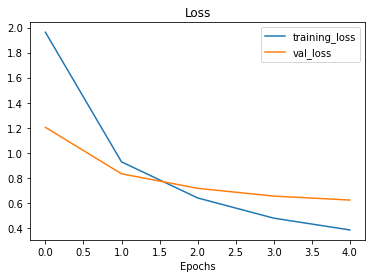

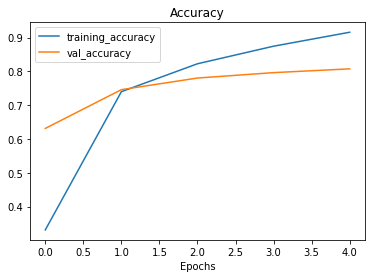

In [ ]:
# Plot loss curves
plot_loss_curves(resnet_history)

In [ ]:
# Create Efficient Net B0 feature extractor model

In [ ]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=10)

# Compile model
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics='accuracy')

# Fit model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data_10_percent,
                       validation_steps=len(test_data_10_percent),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                              experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210720-134638
Epoch 1/5
24/24 [==============================] - 35s 1s/step - loss: 1.8557 - accuracy: 0.4467 - val_loss: 1.2839 - val_accuracy: 0.7476
Epoch 2/5
24/24 [==============================] - 21s 895ms/step - loss: 1.0537 - accuracy: 0.7840 - val_loss: 0.8521 - val_accuracy: 0.8304
Epoch 3/5
24/24 [==============================] - 21s 893ms/step - loss: 0.7474 - accuracy: 0.8387 - val_loss: 0.6817 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 21s 896ms/step - loss: 0.5988 - accuracy: 0.8787 - val_loss: 0.5929 - val_accuracy: 0.8620
Epoch 5/5
24/24 [==============================] - 21s 893ms/step - loss: 0.5055 - accuracy: 0.9013 - val_loss: 0.5434 - val_accuracy: 0.8676


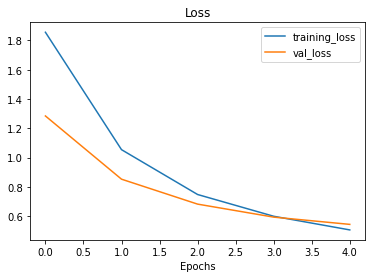

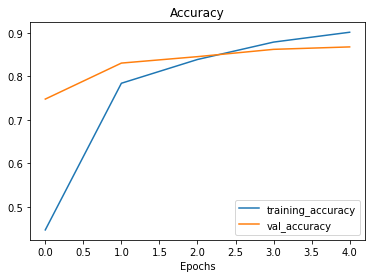

In [ ]:
# Plot the loss curves
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# The above models were "As is" models, basically meaning we didn't change them at all

In [ ]:
# Check the number of layers in efficientnet model
len(efficientnet_model.layers[0].weights)

309

In [ ]:
# Comparing our models using tensorboard

In [ ]:
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetb0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures using10% of the training data." \
--one_shot 

2021-07-20 13:48:40.295430: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


In [ ]:
# The tensorflow experiments are here
# https://tensorboard.dev/experiment/0YKjOEmXQN6FziWHlby3xg/#scalars

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-07-20 13:49:24.967013: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id "test"

2021-07-20 13:49:31.870969: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will delete the experiment on https://tensorboard.dev with the
following experiment ID:

test

You have chosen to delete an experiment. All experiments uploaded
to TensorBoard.dev are publicly visible. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


In [ ]:
# Confirm the deletion by rechecking what experiments you have left

In [ ]:
# Try the MobileNetV2 architecture
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'

In [ ]:
# Import the MobileNetV2 architecture
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
# Create the model
mobilenet_model = tf.keras.Sequential(
    MobileNetV2(input_shape=(224,224,3),classes=10,include_top=False),
    tf.keras.layers.Dense(10,activation='softmax')
)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Compile the mobilenet model
mobilenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics='accuracy')

In [ ]:
# Fit the mobilenet model
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data_10_percent,
                       validation_steps=len(test_data_10_percent),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                              experiment_name="mobilenet_model")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet_model/20210720-141455
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


TypeError: ignored

In [ ]:
mobilenet_model.summary()

In [ ]:
# Try making an Inception model
inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'

In [ ]:
# Create inception model
inception_model = create_model(inception_url,num_classes=10)

# Compile inception model
inception_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics='accuracy')

# Fit inception model
inception_history =  inception_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data_10_percent,
                       validation_steps=len(test_data_10_percent),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                              experiment_name="inception_model")])

In [ ]:
inception_model.summary()